In [1]:
!pip install wandb
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.layers import Dense,MaxPool2D,Flatten,Conv2D
import os
from tensorflow.keras import layers
from wandb.keras import WandbCallback
import wandb
from sklearn.metrics import classification_report, confusion_matrix

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 139 kB 49.2 MB/s 
     |████████████████████████████████| 180 kB 42.3 MB/s 
     |████████████████████████████████| 97 kB 6.0 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=a8f70aa9b0baa3b546a1ce5e1e63d7428607c3294ac33752df05ae195e54a727
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=4a99b04c6154cb0ab390d3dfa9db40586e11810577c8f0f3f5d1fdabd9853869
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [2]:
!pip install kaggle

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle

In [4]:
!kaggle datasets download -d ashishjangra27/gender-recognition-200k-images-celeba

 99% 1.31G/1.32G [00:11<00:00, 144MB/s]
100% 1.32G/1.32G [00:11<00:00, 124MB/s]


In [5]:
!unzip -qq gender-recognition-200k-images-celeba.zip

In [6]:
dataset_train='/content/Dataset/Train'
dataset_test='/content/Dataset/Test'
dataset_val='/content/Dataset/Validation'
width=height=64
batch_size=256

In [7]:
data_generator=ImageDataGenerator(
rescale=1/255,
horizontal_flip=True,
)


In [8]:
train_data=data_generator.flow_from_directory(
    dataset_train,
    target_size=(width,height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    subset='training'
)
val_data = data_generator.flow_from_directory(dataset_val,
                                                    target_size = (width, height),
                                                    class_mode = 'categorical',
                                                    batch_size = batch_size,
                                                    shuffle = False
                                                    )
test_data=data_generator.flow_from_directory(
    dataset_test,
    target_size=(width,height),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
  
)

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.
Found 20001 images belonging to 2 classes.


In [9]:
base_model = tf.keras.applications.VGG16(
    input_shape=(width, height, 3),
    include_top = False,
    weights = 'imagenet',
    pooling = 'max'
    )

58900480/58889256 [==============================] - 1s 0us/step


In [10]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [11]:
model = tf.keras.Sequential([
        base_model,
        Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(2, activation='sigmoid'),              
])

In [12]:
wandb.init(project="Gender_classification")

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [13]:
config = wandb.config
config.learning_rate = 0.001
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,optimizer=tf.keras.optimizers.Adam(learning_rate=config.learning_rate),
    metrics=['accuracy']
)

In [14]:
model.fit(train_data,
          steps_per_epoch = train_data.samples / batch_size,
          validation_data = val_data,
          validation_steps = val_data.samples / batch_size,
          epochs = 5
)



Epoch 1/5
625/625 [==============================] - 404s 578ms/step - loss: 0.1658 - accuracy: 0.9344 - val_loss: 0.1203 - val_accuracy: 0.9544
Epoch 2/5
625/625 [==============================] - 358s 572ms/step - loss: 0.0793 - accuracy: 0.9701 - val_loss: 2.5162 - val_accuracy: 0.6154
Epoch 3/5
625/625 [==============================] - 358s 572ms/step - loss: 0.0651 - accuracy: 0.9761 - val_loss: 0.1311 - val_accuracy: 0.9602
Epoch 4/5
625/625 [==============================] - 358s 572ms/step - loss: 0.0582 - accuracy: 0.9786 - val_loss: 0.0838 - val_accuracy: 0.9711
Epoch 5/5
625/625 [==============================] - 357s 571ms/step - loss: 0.0543 - accuracy: 0.9806 - val_loss: 0.0743 - val_accuracy: 0.9739


In [15]:
Y_pred = model.predict(test_data)
y_pred = np.argmax(Y_pred, axis= 1)

print(confusion_matrix(test_data.classes, y_pred))
targets = set(test_data.class_indices.keys())
print('classification_report:')
print(classification_report(test_data.classes, y_pred, target_names= targets))

[[11463    79]
 [  320  8139]]
classification_report:
              precision    recall  f1-score   support

        Male       0.97      0.99      0.98     11542
      Female       0.99      0.96      0.98      8459

    accuracy                           0.98     20001
   macro avg       0.98      0.98      0.98     20001
weighted avg       0.98      0.98      0.98     20001



In [16]:
!pip install retina-face
from retinaface import RetinaFace
import cv2
import matplotlib.pyplot as plt

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.1.1-py3-none-any.whl size=14211 sha256=7d45fa492d7450b4412e65322005f0879dc3ad105baf6772d7e5e8b80d7822b8
  Stored in directory: /root/.cache/pip/wheels/0c/45/5c/0c6bf549923e217b4a0fd24a90ce36e0d183ca50b7a1a7306d
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


In [17]:
def predict(image_path):
    faces = RetinaFace.extract_faces(img_path= image_path, align= True)
    image = faces[0]
    image = cv2.resize(image, (width, height))
    plt.imshow(image)
    image = image / 255.0
    image = np.expand_dims(image, axis= 0)
    res = np.argmax(model.predict(image))
    if res == 0:
        print('Female\n')
    elif res==1:
        print('Male\n')



Directory  /root /.deepface created
Directory  /root /.deepface/weights created
retinaface.h5 will be downloaded from the url https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/retinaface.h5
To: /root/.deepface/weights/retinaface.h5
100%|██████████| 119M/119M [00:02<00:00, 39.8MB/s]


Male



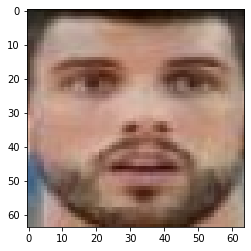

In [18]:
predict('2.jpg')

Female



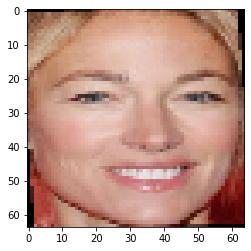

In [19]:
predict('3.jpg')